# TROPICAL CYCLONES

In [1]:
%matplotlib notebook

In [2]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from xmldic import bxml

from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap

from datetime import datetime,timedelta

from family import family

# FUNCTIONS

##### Holland Parameter B

In [3]:
def hollparam(vmax, rhoa, dp):
    return (vmax**2*rhoa*np.exp(1))/(dp)

##### Pressure

In [4]:
# r = radius
# pc = Central Pressure (Pc)
# dp = Pressure Drop=(Pn-Pc)
# rmax = Radius of max winds (Rmax)
# b = Holland's parameter (B)

In [5]:
def pres(r, dp, pn, rmax, b):
    pc=pn-dp
    return pc+dp*np.exp(-(rmax/r)**b)

In [6]:
def pres2d(l1,l2,dp, pn, rmax, b):
    r=np.sqrt(l1**2+l2**2)
    pc=pn-dp
    return pc+dp*np.exp(-(rmax/r)**b)

##### Velocity

In [7]:
def vel(r,b,rhoa,rmax,maxR,kh,dp):
    x=0.5+(r-rmax)/(maxR-rmax)*kh  
    return (b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b))**x

In [8]:
def vel2d(l1,l2,vtx,vty, dp, pn, rmax, b, k):
    r=np.sqrt(l1**2+l2**2)
    theta=np.arctan2(l2,l1)
    
    # velocity (def vel)
    x=0.5+(r-rmax)/(maxR-rmax)*k
    vr=(b/rhoa*(rmax/r)**b*dp*np.exp(-(rmax/r)**b))**x
     
    vx=-vr*np.sin(theta)
    vxs=vx+vtx*(1.-np.exp(-(rmax/r)**b))
    
    vy=vr*np.cos(theta)
    vys=vy+vty*(1.-np.exp(-(rmax/r)**b))

    return vx,vy,vxs,vys

##### Exp function used in the plots

In [9]:
def expf(t,A,K,C):
    return A*np.exp(K*t)+C

## SET GENERAL PARAMETERS

In [10]:
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

In [11]:
npmin=2 # ??????

kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
kmax=0.15 # upper limit for k 

pn=101000.
dpmin=10.e2  # minimum value of  pressure drop P_central - P_env(=101kPa).
dpmax=200.e2   # maximum value of  pressure drop P_central - P_env(=101kPa).

rvmaxmin=10.e3  # default minimum value of Rmax[m] 

bmin=0.8 # minimum value of holland parameter b
#bmax=2.5
bmax=1.8  # maximum value of holland parameter b
b0=1.2  # initial estimation of holland parameter b

rmax0=20.e3  # intial estimation for radius of maximum wind [m] (20km)
maxR=500.e3  # maximum radius of TC [m] (500Km)

In [12]:
nb=10000  #size of random numbers used

fk=0.92  # coefficient for going from 1m to 10m in velocities 

fvtr=1.0

In [13]:
print fk

0.92


## TEST HOLLAND EQUATION

##### Inpdata

In [16]:
pn_test=100600.  
vmax_test=125*1.852/3.6
k_test=0.14
rmax_test=15*1852
pc_test=93400
dp_test=pn_test-pc_test


kh_test=0.14

lat_test=17.4
#vt_test=4.8215#15*1.852/3.6
vtx_test=0.328749
vty_test=4.81028
vt_test=(vtx_test**2+vty_test**2)**(0.5)

print kh_test
print vmax_test
print rmax_test
print dp_test
print pc_test
print dp_test
#print vt_test
#vtr:  4.8215
#vtrx:  0.328749
#vtry:  4.81028

#TC MATTHEW


#AL, 14, 2016100406,   , BEST,   0, 174N,  745W, 125,  934, HU,  34, NEQ,  160,  150,  100,  120, 1006,  250,  15, 150,  15,   L,   0,    ,   0,   0,    MATTHEW, D, 12, NEQ,  240,  240,  210,  240, genesis-num, 024, 


0.14
64.3055555556
27780
7200.0
93400
7200.0


##### Calculate vmax0, vmaxvt

In [17]:
vmax0k_test=vmax_test*fk
print vmax0k_test

vmaxvt_test=vmax0k_test-vt_test
print vmaxvt_test

59.1611111111
54.3396103506


In [18]:
# in WR2H
#deltalatvmax=rmax/deg2m*sinfivmax  # for each Rmax we compute the lat deviation for the velocity
#latvmax=lat+deltalatvmax
latvmax=lat_test
fvmax=2*omega*np.abs(np.sin(np.radians(latvmax))) # Coriolis coef f  
fvmax2=rmax_test*fvmax/2
vmax1_test=((vmaxvt_test+fvmax2)**2-fvmax2**2)**0.5

print 'vmax bull: ', vmax_test
print 'vmax 10 min: ', vmax0k_test
print 'vmax without vt: ', vmaxvt_test
print 'vmax1: ', vmax1_test

vmax bull:  64.3055555556
vmax 10 min:  59.1611111111
vmax without vt:  54.3396103506
vmax1:  54.9404167137


##### Calculate b

In [19]:
b_test=hollparam(vmax_test, rhoa, dp_test)
b0k_test=hollparam(vmax0k_test, rhoa, dp_test)
bvt_test=hollparam(vmaxvt_test, rhoa, dp_test)
b1_test=hollparam(vmax1_test, rhoa, dp_test)

print b_test
print b0k_test
print bvt_test
print b1_test

1.79538178604
1.51961114371
1.28201428881
1.31052021415


##### Radius, grid

In [20]:
r_test=np.linspace(0,5*rmax_test,300)

ni,nj=1000,1000
xl=np.linspace(-maxR, maxR,ni+1)
yl=np.linspace(-maxR, maxR,nj+1)

q1,q2=np.meshgrid(xl,yl)

##### PRESSURE

In [21]:
# 1D
p_test=pres(r_test,dp_test,pn_test,rmax_test,b_test)
p0k_test=pres(r_test,dp_test,pn_test,rmax_test,b0k_test)
pvt_test=pres(r_test,dp_test,pn_test,rmax_test,bvt_test)
p1_test=pres(r_test,dp_test,pn_test,rmax_test,b1_test)

#2D
p2_test=pres2d(q1,q2,dp_test,pn_test,rmax_test,b_test)
p20k_test=pres2d(q1,q2,dp_test,pn_test,rmax_test,b0k_test)
p2vt_test=pres2d(q1,q2,dp_test,pn_test,rmax_test,bvt_test)
p21_test=pres2d(q1,q2,dp_test,pn_test,rmax_test,b1_test)

<IPython.core.display.Javascript object>


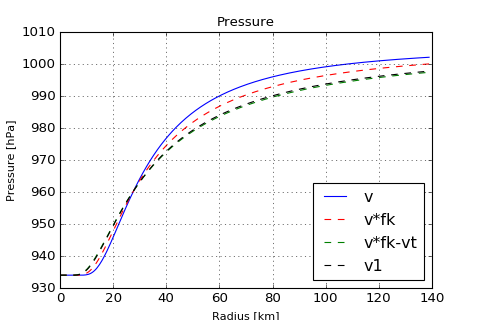

In [22]:
plt.figure(figsize=(6,4))
plt.plot(r_test/1000,p_test/100,label='v')
plt.plot(r_test/1000,p0k_test/100, '--r',label='v*fk')
plt.plot(r_test/1000,pvt_test/100, '--g',label='v*fk-vt')
plt.plot(r_test/1000,p1_test/100, '--k',label='v1')
plt.grid(True)
plt.xlabel('Radius [km]',fontsize=10)
plt.ylabel('Pressure [hPa]',fontsize=10)
plt.title('Pressure',fontsize=12)
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


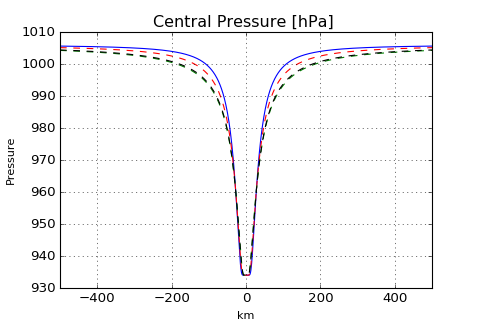

In [23]:
plt.figure(figsize=(6,4))
plt.plot(q1[0,:]/1000,p2_test[500,:]/100)
plt.plot(q1[0,:]/1000,p20k_test[500,:]/100,'--r')
plt.plot(q1[0,:]/1000,p2vt_test[500,:]/100,'--g')
plt.plot(q1[0,:]/1000,p21_test[500,:]/100,'--k')

plt.xlabel('km',fontsize=10)
plt.ylabel('Pressure',fontsize=10)
plt.title('Central Pressure [hPa] ')

plt.grid(True)
plt.xlim((-500,500))
plt.show()

<IPython.core.display.Javascript object>


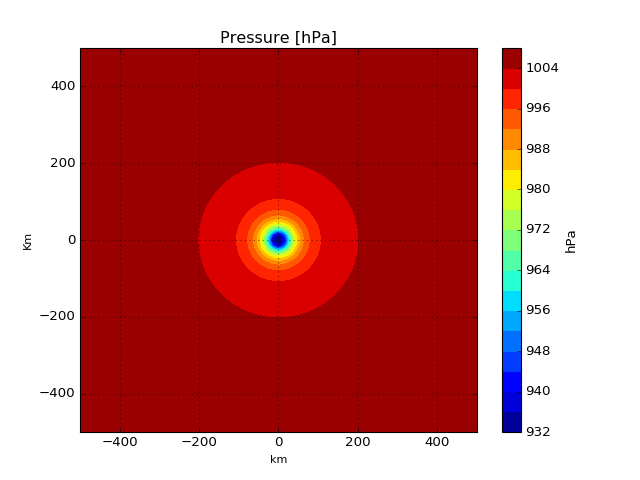

In [24]:
plt.figure(figsize=(8,6))
plt.contourf(q1/1000,q2/1000,p2_test/100,20)
plt.xlabel('km',fontsize=10)
plt.ylabel('Km',fontsize=10)
plt.title('Pressure [hPa]')
plt.colorbar(label='hPa')
plt.grid(True)
plt.show()

##### VELOCITY

In [25]:
#1D
v_test=vel(r_test,b_test,rhoa,rmax_test,maxR,kh_test,dp_test)
v0k_test=vel(r_test,b0k_test,rhoa,rmax_test,maxR,kh_test,dp_test)
vvt_test=vel(r_test,bvt_test,rhoa,rmax_test,maxR,kh_test,dp_test)
v1_test=vel(r_test,b1_test,rhoa,rmax_test,maxR,kh_test,dp_test)

In [26]:
vx_test,vy_test,vxs_test,vys_test=vel2d(q1,q2,vtx_test,vty_test,dp_test,pn_test,rmax_test,b_test, kh_test)
vxvt_test,vyvt_test,vxsvt_test,vysvt_test=vel2d(q1,q2,vtx_test,vty_test,dp_test,pn_test,rmax_test,bvt_test, kh_test)

In [27]:
vel_test=np.sqrt(vx_test**2+vy_test**2) # without translational velocity
velvs_test=np.sqrt(vxs_test**2+vys_test**2)# with translational velocity
velvt_test=np.sqrt(vxvt_test**2+vyvt_test**2) # without translational velocity
velvsvt_test=np.sqrt(vxsvt_test**2+vysvt_test**2)# with translational velocity

<IPython.core.display.Javascript object>


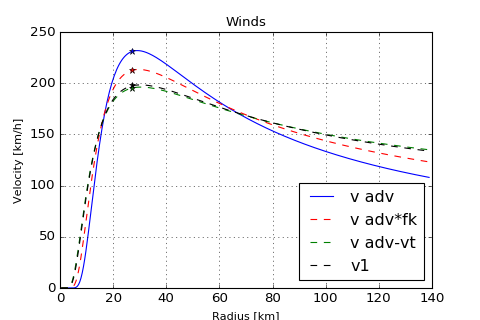

In [28]:
plt.figure(figsize=(6,4))
plt.plot(r_test/1000,v_test*3.6, '-b', label='v adv')
plt.plot(r_test/1000,v0k_test*3.6,'--r', label='v adv*fk')
plt.plot(r_test/1000,vvt_test*3.6,'--g',label='v adv-vt')
plt.plot(r_test/1000,v1_test*3.6,'--k',label='v1')
plt.plot(rmax_test/1000, vmax_test*3.6, '*b')
plt.plot(rmax_test/1000, vmax0k_test*3.6, '*r')
plt.plot(rmax_test/1000, vmaxvt_test*3.6, '*g')
plt.plot(rmax_test/1000, vmax1_test*3.6, '*k')
plt.grid(True)
plt.xlabel('Radius [km]',fontsize=10)
plt.ylabel('Velocity [km/h]',fontsize=10)
plt.title('Winds',fontsize=12)
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


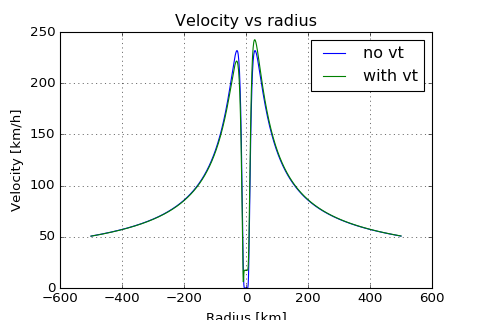

In [29]:
plt.figure(figsize=(6,4))
plt.plot(q1[0,:]/1000,vel_test[ni/2,:]*3.6,label='no vt')
plt.plot(q1[0,:]/1000,velvs_test[ni/2,:]*3.6,label='with vt')

#plt.plot(q1[0,:]/1000,velvt[ni/2,:]*3.6,label='no vt, vmax-vt ')
#plt.plot(q1[0,:]/1000,velvsvt[ni/2,:]*3.6,label='with vt,vmax-vt')

plt.xlabel('Radius [km]',fontsize=12)
plt.ylabel('Velocity [km/h]',fontsize=12)
plt.title('Velocity vs radius')

plt.grid(True)
plt.legend(loc=0)
plt.show()

<IPython.core.display.Javascript object>


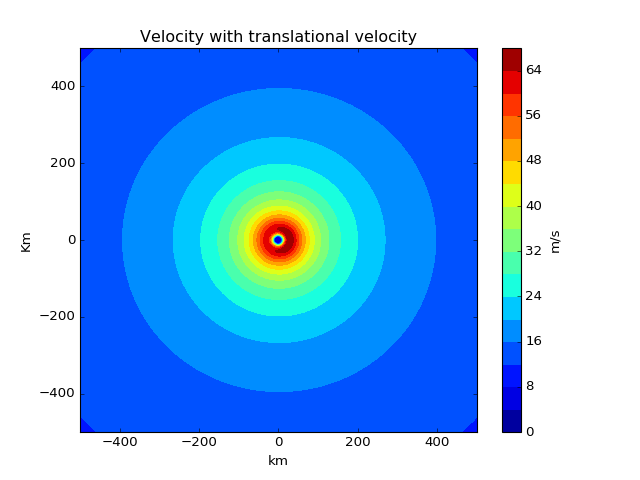

In [30]:
plt.figure(figsize=(8,6))
plt.contourf(q1/1000,q2/1000,velvs_test,20)
#plt.streamplot(q1/1000,q2/1000,vxs_test,vys_test, color=velvs_test, linewidth=0.1*velvs_test)
plt.xlabel('km',fontsize=12)
plt.ylabel('Km',fontsize=12)
plt.title('Velocity with translational velocity')

plt.colorbar(label='m/s')
plt.show()

#  HOLLAND PARAMTER EVALUATION USING TC bull in GDACS

Input data from the bulletins (txt or xml format).
Files stored in a folder with the path name defined as '/mnt/web/cycloneSurgeVM/' + TC_number_NOAAorJTWC/Bulletin_number/

See the example below (latest input files created ...)

In [31]:
import os
def all_subdirs_of(b='.'):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
  return result

##### Best Track Data

In [14]:
#TC MATTHEW

pcBT=93400
pnBT=100600
dpBT=pnBT-pcBT
rmaxBT=15*1852
vmaxBT=125*1.852/3.6
vtBT=15*1.852/3.6
#AL, 14, 2016100406,   , BEST,   0, 174N,  745W, 125,  934, HU,  34, NEQ,  160,  150,  100,  120, 1006,  250,  15, 150,  15,   L,   0,    ,   0,   0,    MATTHEW, D, 12, NEQ,  240,  240,  210,  240, genesis-num, 024, 
print vmaxBT
print rmaxBT
print vtBT
print dpBT

64.3055555556
27780
7.71666666667
7200


## 1) INPUT FILES (all ftimes)

In [15]:
path='/mnt/web/cycloneSurgeVM/'

In [18]:
#dirs=all_subdirs_of(path)
#print dirs

In [19]:
#latest_subdir = max(dirs, key=os.path.getmtime)
latest_subdir=path+'1000316_NOAA'
print latest_subdir

/mnt/web/cycloneSurgeVM/1000316_NOAA


##### Define bulletin

In [20]:
bul=24

In [21]:
infolder=latest_subdir+'/{}'.format(bul)
print infolder

/mnt/web/cycloneSurgeVM/1000316_NOAA/24


In [22]:
# files inside infolder
#os.listdir(infolder)

The main files with info are bulInfo, info, inpData. We can parse those files to get the info 

##### Info file



In [23]:
infofile=infolder+'/info.xml'
info=bxml(infofile)
print('Info in info.xml file:')
print info.setexp

Info in info.xml file:
basin: Atlantic
bulDate: 04 Oct 2016  03:00:00
bulNo: '24'
fk: '0.81'
hurId: '1000316'
hurName: MATTHEW-16
landfall: '1'
n: '100000'
source: Tropical Cyclone Bulletin through GDACS/PDC
stormsurge: '0'
timefactor: '1'



In [24]:
bulNo=np.int(info.setexp.bulNo); print bulNo

stitle=info.setexp.source ; print stitle

hurName=info.setexp.hurName; print hurName

bulDate=info.setexp.bulDate; print bulDate


24
Tropical Cyclone Bulletin through GDACS/PDC
MATTHEW-16
04 Oct 2016  03:00:00


##### InpData

In [25]:
inpfile=infolder+'/inpData.txt'
inpdat=pandas.read_csv(inpfile,header=0,delimiter='\t',usecols=np.arange(0,17))
print('Info in inpData.txt file in: '+ inpfile+'\n')
inpdat

Info in inpData.txt file in: /mnt/web/cycloneSurgeVM/1000316_NOAA/24/inpData.txt



,time,lat,long,vmax,64ne,64se,64sw,64nw,50ne,50se,50sw,50nw,34ne,34se,34sw,34nw,notes
0,0,16.9,-74.6,64.300,35,30,30,30,70,60,50,50,160,100,90,120,0
1,9,18.3,-74.5,64.300,35,35,30,30,80,60,50,60,160,110,90,120,0
2,21,20.0,-74.4,61.728,40,40,35,35,80,70,60,70,170,130,100,120,0
3,33,21.8,-75.2,59.156,50,50,35,40,90,90,60,70,180,160,110,130,0
4,45,23.4,-76.2,56.584,0,0,0,0,90,80,60,80,180,180,110,140,0
5,69,26.6,-78.7,54.012,0,0,0,0,110,100,70,90,210,190,130,170,0
6,93,30.0,-79.6,51.440,0,0,0,0,0,0,0,0,0,0,0,0,0
7,117,33.3,-77.6,46.296,0,0,0,0,0,0,0,0,0,0,0,0,0


Reading the inpData into a dictionary 

In [26]:
# all data (time 0 and forecasts)
time=inpdat['time'].values
lat=inpdat['lat'].values
lon=inpdat['long'].values
vmax=inpdat['vmax'].values
ne64=inpdat['64ne'].values
se64=inpdat['64se'].values
sw64=inpdat['64sw'].values
nw64=inpdat['64nw'].values
ne50=inpdat['50ne'].values
se50=inpdat['50se'].values
sw50=inpdat['50sw'].values
nw50=inpdat['50nw'].values
ne34=inpdat['34ne'].values
se34=inpdat['34se'].values
sw34=inpdat['34sw'].values
nw34=inpdat['34nw'].values

Lat and Lon sign


In [27]:
# ?????
sig=np.sign(lon) ; print sig # get the sign of longitute 
sig1=sig[0] ; print sig1 # uses the first sign to set the adjustment below. 

m=sig != sig1  ; print m # map the values of lon that have sign different from the first lon

print sum(m)

if sum(m)>0:
# adjust the lon values going from -180:180
        if sig1 > 0:
                lon[m]=lon[m]+360.
        elif sig1 < 0:
                lon[m]=lon[m]-360.
#lon

[-1. -1. -1. -1. -1. -1. -1. -1.]
-1.0
[False False False False False False False False]
0


Storing the input quantities

In [28]:
TIME =  time
LAT = lat
LON = lon
VMAX0 = vmax

ntime=np.size(TIME) # number of time steps from bulletin

Initialize arrays

In [29]:
deltaptot = np.zeros(ntime)
btot = np.zeros(ntime)
ktot=np.zeros(ntime)
rmaxtot = np.zeros(ntime)
vmax0tot = np.zeros(ntime)
vmax0ktot = np.zeros(ntime)
vmax1tot = np.zeros(ntime)
vtrtot = np.zeros(ntime)
vtrxtot = np.zeros(ntime)
vtrytot = np.zeros(ntime)
rmsetot=np.zeros(ntime)
biastot=np.zeros(ntime)

##### Translation velocity

In [30]:
inpfilevt=infolder+'/vtcal.txt'
print inpfilevt
vtdat=pandas.read_csv(inpfilevt,header=0,delimiter='\t',usecols=np.arange(0,6))
vtdat

/mnt/web/cycloneSurgeVM/1000316_NOAA/24/vtcal.txt


,time1,vtr,cincl,sincl,vtrx,vtry
0,0.0,4.82150,0.071226,0.997178,0.328749,4.81028
1,9.0,4.60585,0.090130,0.995066,0.394628,4.58892
2,21.0,4.58667,-0.187430,0.956024,-0.831010,4.51076
3,33.0,4.94816,-0.480068,0.875445,-2.245120,4.40951
4,45.0,4.83620,-0.581202,0.811918,-2.655430,4.04197
5,69.0,4.92484,-0.532002,0.841878,-2.422720,4.28772
6,93.0,4.41212,0.194152,0.958004,0.762719,4.34570
7,117.0,5.02982,0.616134,0.787470,2.752890,4.20960


In [31]:
timeh=vtdat['time1'].values # h
time=timeh*3600 # sec
vtr=vtdat['vtr'].values 
vtrx=vtdat['vtrx'].values 
vtry=vtdat['vtry'].values 
cincl=vtdat['cincl'].values 
sincl=vtdat['sincl'].values 

Store Vt

In [32]:
# multiply with the coefficient for 1m to 10m transformation (CHECK & remove) 
vtr=vtr*fvtr
vtrx=vtrx*fvtr
vtry=vtry*fvtr

# store variables
SINFI = sincl
COSFI = cincl
VTR = vtr
VTRX = vtrx
VTRY = vtry

In [33]:
print 'VTR', vtr
print 'VTRX', vtrx
print 'VTRY', vtry
print 'SINFI', sincl
print 'COSFI', cincl

VTR [ 4.8215   4.60585  4.58667  4.94816  4.8362   4.92484  4.41212  5.02982]
VTRX [ 0.328749  0.394628 -0.83101  -2.24512  -2.65543  -2.42272   0.762719
  2.75289 ]
VTRY [ 4.81028  4.58892  4.51076  4.40951  4.04197  4.28772  4.3457   4.2096 ]
SINFI [ 0.997178  0.995066  0.956024  0.875445  0.811918  0.841878  0.958004
  0.78747 ]
COSFI [ 0.0712261  0.0901299 -0.18743   -0.480068  -0.581202  -0.532002   0.194152
  0.616134 ]


## 2) LOOP OVER 1 TIME IN Bulletin

### 2.1)  Set Input

##### select time

In [34]:
done=0
t=0
print 'Bulletin Date:', bulDate
print 'Forecast date:', t

Bulletin Date: 04 Oct 2016  03:00:00
Forecast date: 0


##### set var

In [35]:
time = TIME[t]
lat = LAT[t]
lon = LON[t]
vmax0 = VMAX0[t]
V0=np.array([64, 64, 64, 64, 50, 50, 50, 50, 34, 34, 34, 34])*kt2ms*fk #translate knots to m/s
R0=np.array([ne64[t], se64[t], sw64[t], nw64[t], ne50[t], se50[t], sw50[t], nw50[t], ne34[t], se34[t], sw34[t], nw34[t]])*nm2m #translate from nautical miles to m
an=np.array([tetaNE, tetaSE, tetaSW, tetaNW,tetaNE, tetaSE, tetaSW, tetaNW,tetaNE, tetaSE, tetaSW, tetaNW])
vtr = VTR[t]
vtrx = VTRX[t]
vtry = VTRY[t]
sinfi = SINFI[t]
cosfi = COSFI[t]

vmax0k = vmax0*fk


In [36]:
print 'INPUT DATA:'
print 'time: ', time
print 'vmax0 (v adv): ', vmax0
print 'vmax0k (v adv*fk): ', vmax0k
print 'vtr: ', vtr
print 'vtrx: ', vtrx
print 'vtry: ', vtry
print 'sinfi: ', sinfi
print 'cosfi: ', cosfi

INPUT DATA:
time:  0
vmax0 (v adv):  64.3
vmax0k (v adv*fk):  59.156
vtr:  4.8215
vtrx:  0.328749
vtry:  4.81028
sinfi:  0.997178
cosfi:  0.0712261


##### WIND RADII data

Find which radii are not zero and less than  Rmax(=500km)

In [37]:
M=(R0 != 0) & (R0 < maxR)  # find which radii are not zero and less than  Rmax(=500km)

if  np.sum(M) < npmin : # if there are less than 2
        if (done) :  # if not the time[0] use the previous values
                rmax = rmaxtot[t-1]
                b = btot[t-1]
                k = ktot[t-1]

        else:
                rmax = rmax0
                b = b0
                k = kmin

        bias=None
        rmse=None

        dp = vmax0**2*rhoa*np.exp(1)/b # !!!!!!!!! dp definito usando b e vmax adv (se non ci sono i wind radii)
        deltaptot[t] = dp
        btot[t] = b
        rmaxtot[t] = rmax
        vmax0tot[t] = vmax0
        vmax0ktot[t] = vmax0k
        vmax1tot[t] = np.max([vmax0k-vtr, vmax0k/2])
        vtrtot[t] = vtr
        vtrxtot[t] = vtrx
        vtrytot[t] = vtry
        ktot[t] =k
        biastot[t]=bias
        rmsetot[t] = rmse
#                continue

V0 = V0[M]
R = R0[M]
an = an[M]
sinan = np.sin(np.radians(an+90))  # an +90 = angle of tangential wind
cosan=np.cos(np.radians(an+90))

npv=np.size(V0)


Calculate V wind radii (V - translational velocity)

In [38]:
# !!! usata rmax0
RATIO = (rmax0/R)**b0    # assume exponential decay eqs (13) from JRC report
EXPRATIO = np.exp(-RATIO)  #                       "

VT=vtr*(cosfi * cosan + sinfi * sinan)*(1-EXPRATIO)   # Eq (15) from JRC report
#   VT=vtr*(cosfi * cosan + sinfi * sinan)*(RATIO)

if (lat<0): VT=-VT   # reverse for south hemishpere
VV = V0-VT   # substract translational velocity from TC velocity

# calculate  f WR
deltalatWR=R/deg2m*np.sin(np.radians(an))
latWR=lat+deltalatWR

fWR=2*omega*np.abs(np.sin(np.radians(latWR))) # Coriolis parameter f=2*Omega*sin(lat)
Vnco=((VV+R*fWR/2)**2-(R*fWR/2)**2)**0.5
V=Vnco


Choose valid velocities

In [39]:
M=V>0

if np.sum(M) == 0 : print 'continue'

V0 = V0[M]
VV = VV[M]
V=V[M]
R=R[M]


##### Set Vmax

In [40]:
#--------------------------------------------------
#  calculate  vmax = vmax0 - vt
#--------------------------------------------------
vmax0vt=np.max([vmax0k-vtr,np.max(V)]) # !!! vmax


#--------------------------------------------------
#  calculate coriolis for vmax
#--------------------------------------------------
if (lat>0):
      #sinfivmax=np.sin(fi-90)=-np.cos(fi)
      sinfivmax=-cosfi
else:
      #sinfivmax=np.sin(fi+90)=np.cos(fi)
      sinfivmax=cosfi

print 'Bulletin Date:', bulDate
print 'Forecast date:', t
print 'vmax0: ', vmax0
print 'vmax0k: ', vmax0k
print 'vmax0vt: ', vmax0vt


Bulletin Date: 04 Oct 2016  03:00:00
Forecast date: 0
vmax0:  64.3
vmax0k:  59.156
vmax0vt:  54.3345


### 2.1) MONTE CARLO method (Python)

In [41]:
rh=np.linspace(0,1000000,1000)

Now we estimating the Rmax. A number of ways apply. Next we explore our options

In [42]:
if (npv>npmin):
     K=kmin+(kmax-kmin)*np.random.rand(nb)
elif(done):
     K = np.ones(nb)*ktot[t-1]
else:
     K = np.ones(nb)*kmin

#  DP
DP=dpmin*(dpmax/dpmin)**np.random.rand(nb)

#  Rmax
rvmaxmin=np.min([rvmaxmin,np.min(R)*0.5])  # update the minimum  value for Rmax with the R.min/2 from input
RMAX=rvmaxmin*(np.min(R)*0.99/rvmaxmin)**np.random.rand(nb) # range  min(10000,Rmin/2)<Rmax<.99*Rmin (scaled)

#--------------------------------------------------
# calculate vmax1 = v max0k -vt - Coriolis effect (function of RMAX) ??????????????
#--------------------------------------------------
deltalatvmax=RMAX/deg2m*sinfivmax  # for each Rmax we compute the lat deviation for the velocity
latvmax=lat+deltalatvmax

fvmax=2*omega*np.abs(np.sin(np.radians(latvmax))) # Coriolis coef f

fvmax2=RMAX*fvmax/2
vmax1=((vmax0vt+fvmax2)**2-fvmax2**2)**0.5 # ????????

mask=vmax1<np.max(V)
np.copyto(vmax1,np.max(V),where=mask)

#----------------------------------
# use the random values of vmax,dp above we compute b (from Holland 2010 - eqs (7))
#--------------------------------------------------

B=(rhoa*np.exp(1)/DP)*vmax1**2


m=(B >= bmin) & ( B <= bmax) & (lat*latvmax > 0)  # mask B that fits all 3 criteria
nb1 = np.sum(m) #number of 'True' values

#  mask arrays accordingly
K=K[m]
DP=DP[m]
RMAX=RMAX[m]
B = B[m]

nval = np.size(V)  # number of V > 0
Vcalc = []
RMS = np.zeros(nb1)

try:
        r
except NameError:
        pass
else:
        r=None

# check values for all V
for i in range(nval):
      try:
        r = R[i]
        ratio=(r-RMAX)/(maxR-RMAX)
        X=0.5 + np.min([np.max(ratio,0),1])*K   #compute x using random k  & Rmax
        Vcalc=np.append(Vcalc,((B/rhoa) * DP* (RMAX/r)**B * np.exp(-(RMAX/r)**B))**X)  # compute & store V
      except: print 'sys.exit()'

for i in range (nb1):
      try:
        RMS[i]=np.sqrt(np.average((Vcalc[i::nb1]-V)**2))  # compute deviation from estimated and given values
      except : print 'sys.exit()'

value=nb1
totvalue=nb

# -------------------------------------------------------------------------
# select final velocities
# -------------------------------------------------------------------------
m=RMS == np.min(RMS)  #find minimum RMS

# select the minimizing quantities
rmse=RMS[m][0]
dp=DP[m][0]
b=B[m][0]
rmax=RMAX[m][0]
k=K[m][0]

vmax1 = np.sqrt(b*dp/(rhoa*np.exp(1)))  # compute estimated vmax


# print on screen
var=[t,time,rmse,dp,b,rmax,k,vmax0,vmax0k,vmax0vt,np.max(VV),np.max(V),vmax1]
varn=['t','time','rmse','dp','b','rmax','k' ,'vmax0','vmax0k','vmax0vt','np.max(VV)','np.max(V)','vmax1']
for i in range(np.size(var)):
         print repr(varn[i]).rjust(25), repr(var[i])



                      't' 0
                   'time' 0
                   'rmse' 2.0589784295092017
                     'dp' 7594.9688824441364
                      'b' 1.2250418850580016
                   'rmax' 10501.675176863395
                      'k' 0.13346327947569397
                  'vmax0' 64.299999999999997
                 'vmax0k' 59.155999999999999
                'vmax0vt' 54.334499999999998
             'np.max(VV)' 31.216809029283343
              'np.max(V)' 32.393003865245284
                  'vmax1' 54.555973177619997


In [43]:
b_MCPY=b
rmax_MCPY=rmax
dp_MCPY=dp
k_MCPY=k
vmax0_MCPY=vmax0
vmax0k_MCPY=vmax0k
vmax0vt_MCPY=vmax0vt
vmax1_MCPY=vmax1
pn_MCPY=pn

In [44]:
print 'b MCPY: ', b_MCPY
print 'rmax MCPY: ', rmax_MCPY
print 'dp MCPY: ', dp_MCPY
print 'k MCPY: ', k_MCPY
print 'vmax0 MCPY: ', vmax0_MCPY
print 'vmax0k MCPY: ', vmax0k_MCPY
print 'vmax0vt MCPY: ', vmax0vt_MCPY
print 'vmax1 MCPY: ', vmax1_MCPY


b MCPY:  1.22504188506
rmax MCPY:  10501.6751769
dp MCPY:  7594.96888244
k MCPY:  0.133463279476
vmax0 MCPY:  64.3
vmax0k MCPY:  59.156
vmax0vt MCPY:  54.3345
vmax1 MCPY:  54.5559731776


In [45]:
print 'Bulletin Date:', bulDate
print 'Forecast date:', t
print 'vmax0: ', vmax0
print 'vmax0k: ', vmax0k
print 'vmax0vt: ', vmax0vt

Bulletin Date: 04 Oct 2016  03:00:00
Forecast date: 0
vmax0:  64.3
vmax0k:  59.156
vmax0vt:  54.3345


##### Plot Vg

In [46]:
Rmax=rmax

rx=np.arange(100)
ex=np.log(max(R)*1.2/1000.)/100.

r=expf(rx,1000.,ex,0.)

ratio=(r-rmax)/(maxR-rmax)

mask=ratio<0.
np.copyto(ratio,0.,where=mask)
mask=ratio>1.
np.copyto(ratio,1.,where=mask)

xh=0.5 + ratio*k

Vg=( (b/rhoa) * dp* (Rmax/r)**b * np.exp(-(Rmax/r)**b) )**xh

[fVg]=family(r,Vg)

bias=np.average(fVg(R)-V)
rmse=np.sqrt(np.average((fVg(R)-V)**2))



In [47]:
v_MCPY=vel(rh,b_MCPY,rhoa,rmax_MCPY,maxR,k_MCPY,dp_MCPY)
pres_MCPY=pres(rh, dp_MCPY, pn_MCPY, rmax_MCPY, b_MCPY)

<IPython.core.display.Javascript object>


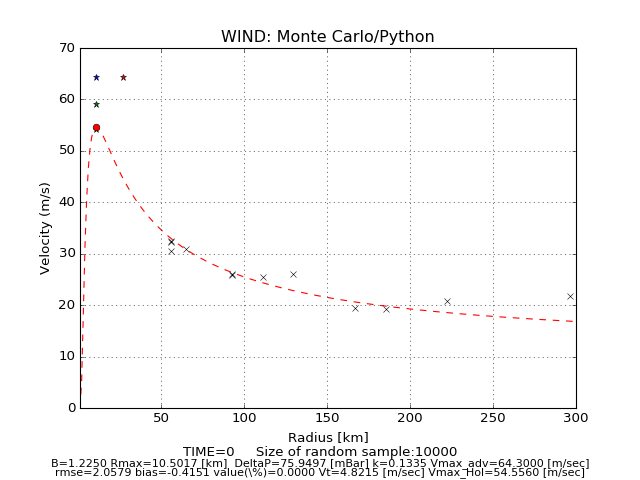

In [48]:
# WIND
plt.figure(figsize=(8,6))
plt.plot(rmaxBT/1000, vmaxBT, '*r') # vmax BT
plt.plot(rmax_MCPY/1000, vmax0_MCPY, '*b') # vmax adv
plt.plot(rmax_MCPY/1000, vmax0k_MCPY, '*g')  # vmax adv * fk
plt.plot(rmax_MCPY/1000, vmax0vt_MCPY, '*g')  # vmax adv * fk * vt
plt.plot(rmax_MCPY/1000, vmax1_MCPY, 'or')    # ottenuta utilizzando i nuovi parametri di Holland
#plt.plot(rmaxBT/1000, vmaxBT, '*r') 
plt.plot(R/1000,V,'kx')
plt.plot(rh/1000, v_MCPY,'r--')
plt.axis([r.min()/1000,300.,0.,70.])
plt.xlabel('Radius [km]')
plt.ylabel('Velocity (m/s)')
plt.title('WIND: Monte Carlo/Python')
plt.grid(True)
plt.figtext(.5,.05,'TIME='+np.str(time)+'     Size of random sample:'+np.str(nb),horizontalalignment='center')
plt.figtext(.5,.03,'B='+'%.4f' % b+' Rmax='+'%.4f' % (Rmax/1000)+' [km]  DeltaP='+'%.4f' % (dp/100)+' [mBar] k='+'%.4f' % k+' Vmax_adv='+'%.4f' % vmax0+' [m/sec]',horizontalalignment='center',size='small')
plt.figtext(.5,.01,'rmse='+'%.4f' % rmse+' bias='+'%.4f' % bias+' value(\%)='+'%.4f' %(value/totvalue*100)+' Vt='+'%.4f' % vtr+' [m/sec] Vmax_Hol='+'%.4f' % vmax1+' [m/sec]',horizontalalignment='center',size='small')
plt.subplots_adjust(bottom=.15)
plt.show()

<IPython.core.display.Javascript object>


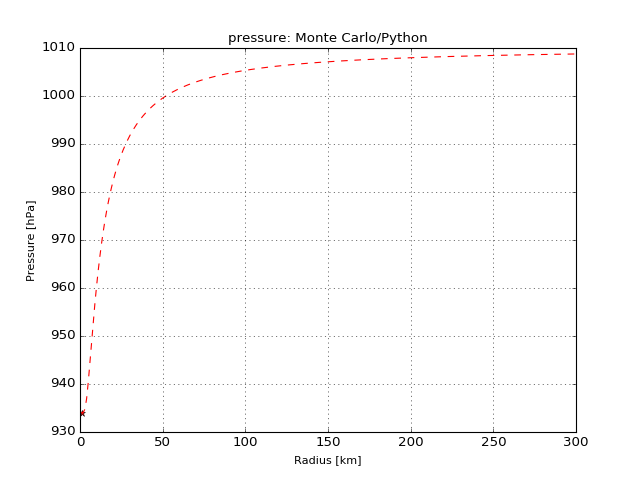

In [49]:
# PRESSURE
plt.figure(figsize=(8,6))
plt.plot(1, pcBT/100, '*r') # pc BT
plt.plot(rh/1000,pres_MCPY/100, '--r')
plt.grid(True)
plt.xlabel('Radius [km]',fontsize=10)
plt.ylabel('Pressure [hPa]',fontsize=10)
plt.title('pressure: Monte Carlo/Python',fontsize=12)
plt.axis([0,300.,930.,1010.])
plt.show()

## 2.2) Scipy method

### 2.2.1) TEST 1: 
#####           Input: vmax, Wind Radii
#####          Unknown: B, Rmax, dP, k 

##### Function

In [60]:
# p[0] = B
# p[1] = Rmax
# p[2] = dP
# p[3] = k

from scipy.optimize import minimize, fmin_slsqp

def slsqp1(R,V,maxR,rho,vmax):
        dpmin=10.e2  # minimum value of  pressure drop P_central - P_env(=101kPa).
        dpmax=200.e2   # maximum value of  pressure drop P_central - P_env(=101kPa).
        kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
        kmax=0.15 # upper limit for k (->xn=.65)  WHY?
        bmin=0.8
        bmax=1.8

        def func(p,x): # v(r) Holland
                 return (p[0]/rho*(p[1]/x)**p[0]*p[2]*np.exp(-(p[1]/x)**p[0]))**(0.5+(x-p[1])/(maxR-p[1])*p[3])

        def errf(p,x,y):
            return np.sum((func(p,x)-y)**2)

        def cf(p,x,y): # Holland parameter (B)
                 return p[0]-vmax**2*rho*np.exp(1.)/p[2]

        
        p0=[1.2,20000,400,.15] # b, rmax, dp, x (funzione di k) prima 0.5

        bp=[(bmin,bmax),(5000,R.min()*.99),(dpmin,dpmax),(kmin,kmax)]

        
        res1 = minimize(errf, p0, args=(R, V), method='L-BFGS-B', bounds=bp, \
                        options={'disp': True, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})

        res2 = minimize(errf, p0, args=(R, V), method='SLSQP', bounds=bp, tol=1e-3, options={'disp': True, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100, 'ftol': 1e-06})

        res3 = fmin_slsqp(errf, p0, bounds=bp, args=(R, V),f_ieqcons=cf,acc=1e-5)
        
        
        return func,res1.x,res2.x, res3


##### Input

In [61]:
print 'Vmax0: ', vmax0
print 'Vmax0k: ', vmax0k
print 'Vmax0vt: ', vmax0vt

Vmax0:  64.3
Vmax0k:  59.156
Vmax0vt:  54.3345


In [62]:
print R
print V

[  64820.   55560.   55560.   55560.  129640.  111120.   92600.   92600.
  296320.  185200.  166680.  222240.]
[ 30.97823206  30.49319381  32.22349092  32.39300387  26.05893179
  25.38152443  25.95095052  26.14524966  21.83217361  19.15348586
  19.3582703   20.75445116]


##### Calculate the missing parameters

In [63]:
fitf1,p2,p3,p4=slsqp1(R,V,maxR,rhoa,vmax0k)

print 'B: ', p2[0], p3[0], p4[0]
print 'Rmax: ', p2[1]/1000, p3[1]/1000, p4[1]/1000
print 'DP: ', p2[2]/100, p3[2]/100, p4[2]/100
print 'k: ', p2[3], p3[3], p4[3]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28.9987689018
            Iterations: 17
            Function evaluations: 107
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.1550859378
            Iterations: 35
            Function evaluations: 214
            Gradient evaluations: 35
B:  1.18155980084 1.18039329838 1.0296233428
Rmax:  20.1256696658 20.0142151537 5.0
DP:  37.5175615199 37.6846962742 119.292706434
k:  0.15 0.15 0.149999999997


##### Store variables

In [64]:
b_SPY=p2[0]
rmax_SPY=p2[1]
dp_SPY=p2[2]
k_SPY=p2[3]
pn_SPY=pn



In [65]:
# Vmax1 # compute estimated vmax
vmax1_LBF= np.sqrt(p2[0]*p2[2]/(rhoa*np.exp(1)))
vmax1_SLS= np.sqrt(p3[0]*p3[2]/(rhoa*np.exp(1)))
vmax1_min= np.sqrt(p4[0]*p4[2]/(rhoa*np.exp(1)))
vmax1_SPY= np.sqrt(b_SPY*dp_SPY/(rhoa*np.exp(1)))
vmax_SPY=vmax1_SPY
print vmax1_LBF
print vmax1_SLS
print vmax1_min
print vmax1_SPY


37.6572840288
37.7224347615
62.6830290304
37.6572840288


##### Create wind and pressure

In [66]:
#Pressure: pres(r, dp, pn, rmax, b)
pres1_LBF=pres(rh, p2[2], pn, p2[1], p2[0])
pres1_SLS=pres(rh, p3[2], pn, p3[1], p3[0])
pres1_min=pres(rh, p4[2], pn, p4[1], p4[0])
pres1_SPY=pres(rh, dp_SPY,pn_SPY,rmax_SPY,b_SPY)
# wind: vel(r,b,rhoa,rmax,maxR,kh,dp)
v1_LBF=vel(rh,p2[0],rhoa,p2[1],maxR,p2[3],p2[2])
v1_SLS=vel(rh,p3[0],rhoa,p3[1],maxR,p3[3],p3[2])
v1_min=vel(rh,p4[0],rhoa,p4[1],maxR,p4[3],p4[2])
v1_SPY=vel(rh, b_SPY, rhoa, rmax_SPY, maxR, k_SPY, dp_SPY)

##### PLOT

<IPython.core.display.Javascript object>


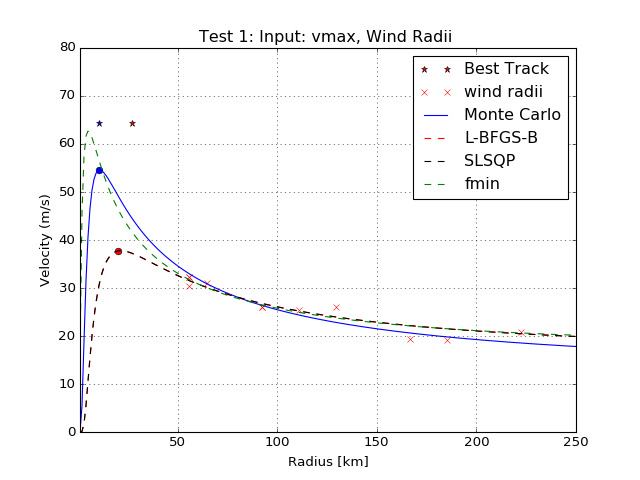

In [67]:
# WINDS
plt.figure(figsize=(8,6))

plt.plot(rmaxBT/1000, vmaxBT, '*r', label='Best Track')
plt.plot(rmax_MCPY/1000, vmax0, '*b')
plt.plot(rmax_MCPY/1000, vmax1_MCPY, 'ob')
plt.plot(rmax_SPY/1000, vmax1_SPY, 'or')

plt.plot(R/1000,V,'rx',label='wind radii')
plt.plot(rh/1000, v_MCPY,'b-',label='Monte Carlo')

plt.plot(rh/1000,v1_LBF,'r--',label='L-BFGS-B')
plt.plot(rh/1000,v1_SLS,'k--',label='SLSQP')
plt.plot(rh/1000,v1_min,'g--',label='fmin')
#plt.plot(rh/1000,v1_SPY,'r-',label='FINAL')

plt.axis([r.min()/1000,250.,0.,80.])
plt.xlabel('Radius [km]')
plt.ylabel('Velocity (m/s)')
plt.title('Test 1: Input: vmax, Wind Radii ')
plt.legend()
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


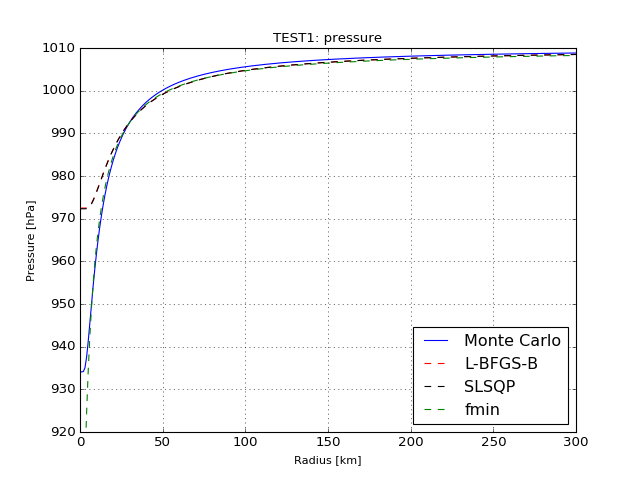

In [74]:
# PRESSURE
plt.figure(figsize=(8,6))
#plt.plot(1,pcBT/100, '*r', label='Best Track')
#plt.plot(1,pnBT/100, '*r', label='Best Track')
plt.plot(rh/1000,pres_MCPY/100, '-b',label='Monte Carlo')
plt.plot(rh/1000,pres1_LBF/100, '--r',label='L-BFGS-B')
plt.plot(rh/1000,pres1_SLS/100,'k--',label='SLSQP')
plt.plot(rh/1000,pres1_min/100,'g--',label='fmin')
plt.grid(True)
plt.xlabel('Radius [km]',fontsize=10)
plt.ylabel('Pressure [hPa]',fontsize=10)
plt.title('TEST1: pressure',fontsize=12)
plt.axis([0,300.,920.,1010.])
plt.legend(loc=0)
plt.show()

### 2.2.2) TEST 2: using BEST TRACK as input
##### Input: vmax, pc, pn, Rmax, Wind Radii
##### unknown: B, k
##### b using Holland

In [87]:
# p[0] = B
# p[1] = k
from scipy.optimize import minimize, fmin_slsqp

def slsqp2(R,V,maxR,rho,vmax, rmax, dp, b):
        kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
        kmax=0.15 # upper limit for k (->xn=.65)  WHY?


        def func(p,x): # v(r) Holland
                 return (b/rho*(rmax/x)**b*dp*np.exp(-(rmax/x)**b))**(0.5+(x-rmax)/(maxR-rmax)*p[0])

        def errf(p,x,y):
            return np.sum((func(p,x)-y)**2)

        def cf(p,x,y): # Holland parameter (B)
                 return b-vmax**2*rho*np.exp(1.)/dp

        
        p0=[.15] # k

        bp=[(kmin,kmax)]

        
        res1 = minimize(errf, p0, args=(R, V), method='L-BFGS-B', bounds=bp, \
                        options={'disp': True, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})

        res2 = minimize(errf, p0, args=(R, V), method='SLSQP', bounds=bp, tol=1e-3, options={'disp': True, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100, 'ftol': 1e-06})

        res3 = fmin_slsqp(errf, p0, bounds=bp, args=(R, V),f_ieqcons=cf,acc=1e-5)
        
        
        return func,res1.x,res2.x, res3

##### Input

In [88]:
print 'INPUT:'
print 'VmaxBT: ', vmaxBT
vmaxBT0k=vmaxBT*fk
print 'VmaxBT0k: ', vmaxBT0k
print 'dpBT: ', dpBT
print 'rmaxBT: ', rmaxBT
print R
print V

INPUT:
VmaxBT:  64.3055555556
VmaxBT0k:  59.1611111111
dpBT:  7200
rmaxBT:  27780
[  64820.   55560.   55560.   55560.  129640.  111120.   92600.   92600.
  296320.  185200.  166680.  222240.]
[ 30.97823206  30.49319381  32.22349092  32.39300387  26.05893179
  25.38152443  25.95095052  26.14524966  21.83217361  19.15348586
  19.3582703   20.75445116]


In [89]:
#b Best Track
bBT0k=hollparam(vmaxBT*fk, rhoa, dpBT)
bBT0=hollparam(vmaxBT, rhoa, dpBT)
print 'HollandBT: ', bBT0
print 'HollandBT0k: ', bBT0k

HollandBT:  1.79538178604
HollandBT0k:  1.51961114371


In [90]:
fitf2,p2,p3,p4=slsqp2(R,V,maxR,rhoa,vmaxBT0k, rmaxBT, dpBT, bBT0k)

print 'k: ', p2[0], p3[0], p4[0]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1346.1704281
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1346.1704281
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
k:  0.0 0.0 0.0


In [79]:
#fitf2,p2,p3,p4=slsqp2(R,V,maxR,rhoa,vmaxBT0k, rmaxBT, dpBT, bBT0)
#print 'k: ', p2[0], p3[0], p4[0]

In [91]:
v_BT0=vel(rh,bBT0,rhoa,rmaxBT,maxR,p2[0], dpBT)
v_BT0k=vel(rh,bBT0k,rhoa,rmaxBT,maxR,p2[0], dpBT)

<IPython.core.display.Javascript object>


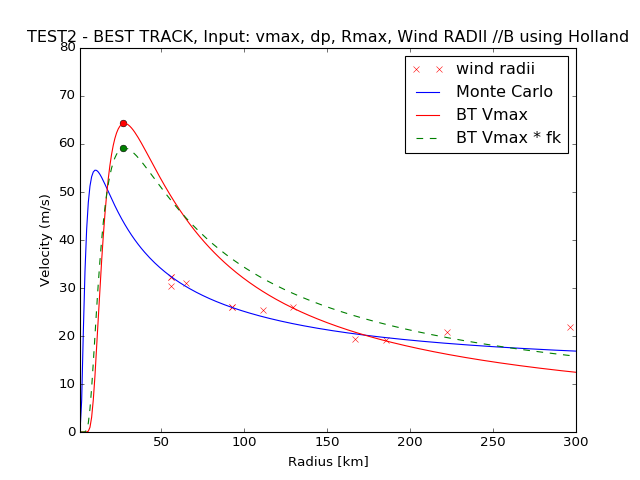

In [92]:
plt.figure(figsize=(8,6))
plt.plot(rmaxBT/1000, vmaxBT*fk, 'og')
plt.plot(rmaxBT/1000, vmaxBT, 'or')

plt.plot(R/1000,V,'rx',label='wind radii')
plt.plot(rh/1000, v_MCPY,'b-',label='Monte Carlo')
plt.plot(rh/1000, v_BT0,'r-', label='BT Vmax')
plt.plot(rh/1000, v_BT0k,'g--', label='BT Vmax * fk')
plt.axis([r.min()/1000,300.,0.,80.])
plt.xlabel('Radius [km]')
plt.ylabel('Velocity (m/s)')
plt.title('TEST2 - BEST TRACK, Input: vmax, dp, Rmax, Wind RADII //B using Holland')
plt.legend()
plt.show()

### 2.2.3) TEST 3: BEST TRACK
##### Input: vmax, pc, pn, Rmax, Wind Radii
##### unknown: B, k --> B calculated using Scipy

In [93]:
# p[0] = B
# p[1] = k
from scipy.optimize import minimize, fmin_slsqp

def slsqp3(R,V,maxR,rho,vmax, rmax, dp):
        kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
        kmax=0.15 # upper limit for k (->xn=.65)  WHY?
        bmin=0.8
        bmax=1.8

        def func(p,x): # v(r) Holland
                 return (p[0]/rho*(rmax/x)**p[0]*dp*np.exp(-(rmax/x)**p[0]))**(0.5+(x-rmax)/(maxR-rmax)*p[1])

        def errf(p,x,y):
            return np.sum((func(p,x)-y)**2)

        def cf(p,x,y): # Holland parameter (B)
                 return p[0]-vmax**2*rho*np.exp(1.)/dp

        
        p0=[1.2,.15] # b, dp, x (funzione di k) prima 0.5

        bp=[(bmin,bmax),(kmin,kmax)]

        
        res1 = minimize(errf, p0, args=(R, V), method='L-BFGS-B', bounds=bp, \
                        options={'disp': True, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})

        res2 = minimize(errf, p0, args=(R, V), method='SLSQP', bounds=bp, tol=1e-3, options={'disp': True, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100, 'ftol': 1e-06})

        res3 = fmin_slsqp(errf, p0, bounds=bp, args=(R, V),f_ieqcons=cf,acc=1e-5)
        
        
        return func,res1.x,res2.x, res3

In [94]:
print 'INPUT:'
print 'VmaxBT: ', vmaxBT
vmaxBT0k=vmaxBT*fk
print 'VmaxBT0k: ', vmaxBT0k
print 'dpBT: ', dpBT
print 'rmaxBT: ', rmaxBT
print R
print V

INPUT:
VmaxBT:  64.3055555556
VmaxBT0k:  59.1611111111
dpBT:  7200
rmaxBT:  27780
[  64820.   55560.   55560.   55560.  129640.  111120.   92600.   92600.
  296320.  185200.  166680.  222240.]
[ 30.97823206  30.49319381  32.22349092  32.39300387  26.05893179
  25.38152443  25.95095052  26.14524966  21.83217361  19.15348586
  19.3582703   20.75445116]


In [95]:
fitf3,p2,p3,p4=slsqp3(R,V,maxR,rhoa,vmaxBT0k, rmaxBT, dpBT) 

print 'B: ', p2[0], p3[0], p4[0]
print 'k: ', p2[1], p3[1], p4[1]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 927.143702773
            Iterations: 8
            Function evaluations: 28
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1346.19742353
            Iterations: 10
            Function evaluations: 40
            Gradient evaluations: 9
B:  0.8 0.8 1.51961156413
k:  0.0 0.0 5.22731911845e-06


In [96]:
#fitf3,p2,p3,p4=slsqp3(R,V,maxR,rhoa,vmaxBT, rmaxBT, dpBT) 

#print 'B: ', p2[0], p3[0], p4[0]
#print 'k: ', p2[1], p3[1], p4[1]

In [97]:
v3_LBF=vel(rh,p2[0],rhoa,rmaxBT,maxR,p2[1],dpBT)
v3_SLS=vel(rh,p3[0],rhoa,rmaxBT,maxR,p3[1],dpBT)
v3_min=vel(rh,p4[0],rhoa,rmaxBT,maxR,p4[1],dpBT)

<IPython.core.display.Javascript object>


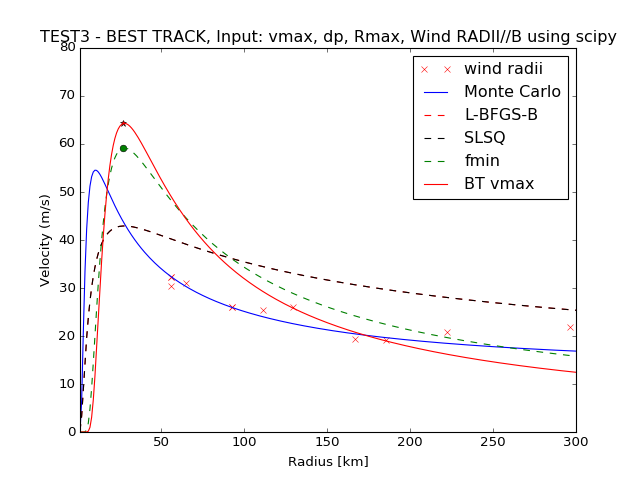

In [98]:
plt.figure(figsize=(8,6))
plt.plot(rmaxBT/1000, vmaxBT*fk, 'og')
plt.plot(rmaxBT/1000, vmaxBT, '*r')
plt.plot(R/1000,V,'rx',label='wind radii')
plt.plot(rh/1000, v_MCPY,'b-',label='Monte Carlo')
plt.plot(rh/1000, v3_LBF,'r--', label='L-BFGS-B')
plt.plot(rh/1000, v3_SLS,'k--', label='SLSQ')
plt.plot(rh/1000, v3_min,'g--', label='fmin')

plt.plot(rh/1000, v_BT0,'r-', label='BT vmax')
#plt.plot(rh/1000, v_BT0k,'g-', label='BT vmax0k')

plt.axis([r.min()/1000,300.,0.,80.])
plt.xlabel('Radius [km]')
plt.ylabel('Velocity (m/s)')
plt.title('TEST3 - BEST TRACK, Input: vmax, dp, Rmax, Wind RADII//B using scipy')
plt.legend()
plt.show()

### 2.2.4) TEST 4: 
##### Input: vmax, dp, Rmax, Wind RADII (including nRmax, nVmax) 
##### Unknown: B, K --> B calculated using scipy

In [99]:
# p[0] = B
# p[1] = k
from scipy.optimize import minimize, fmin_slsqp

def slsqp4(R,V,maxR,rho,vmax, rmax, dp):
        kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
        kmax=0.15 # upper limit for k (->xn=.65)  WHY?
        bmin=0.8
        bmax=1.8

        def func(p,x): # v(r) Holland
                 return (p[0]/rho*(rmax/x)**p[0]*dp*np.exp(-(rmax/x)**p[0]))**(0.5+(x-rmax)/(maxR-rmax)*p[1])

        def errf(p,x,y):
            return np.sum((func(p,x)-y)**2)

        def cf(p,x,y): # Holland parameter (B)
                 return p[0]-vmax**2*rho*np.exp(1.)/dp

        
        p0=[1.2,.15] # b, dp, x (funzione di k) prima 0.5

        bp=[(bmin,bmax),(kmin,kmax)]

        
        res1 = minimize(errf, p0, args=(R, V), method='L-BFGS-B', bounds=bp, \
                        options={'disp': True, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})

        res2 = minimize(errf, p0, args=(R, V), method='SLSQP', bounds=bp, tol=1e-3, options={'disp': True, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100, 'ftol': 1e-06})

        res3 = fmin_slsqp(errf, p0, bounds=bp, args=(R, V),f_ieqcons=cf,acc=1e-5)
        
        
        return func,res1.x,res2.x, res3

In [100]:
print rmaxBT
print vmaxBT
print vmaxBT*fk
#vmax0vt2=vmax0k-vtr
#print vmax0vt2
R1=0
R2=0
RBT=0
VBT=0
R1=np.repeat(rmaxBT, 10000)
R2=np.array(R)
RBT=np.append(R2, R1)
V1=np.repeat(vmaxBT*fk, 10000)
V2=np.array(V)
VBT=np.append(V2, V1)

print RBT
print VBT

27780
64.3055555556
59.1611111111
[ 64820.  55560.  55560. ...,  27780.  27780.  27780.]
[ 30.97823206  30.49319381  32.22349092 ...,  59.16111111  59.16111111
  59.16111111]


In [101]:
fitf4,p2,p3,p4=slsqp4(RBT,VBT,maxR,rhoa,vmaxBT, rmaxBT, dpBT) 
#fitf4,p2,p3,p4=slsqp4(RBT,VBT,maxR,rhoa,vmaxBT*fk, rmaxBT, dpBT) 

print 'B: ', p2[0], p3[0], p4[0]
print 'k: ', p2[1], p3[1], p4[1]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1346.17004659
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 266011.531556
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
B:  1.5196011043 1.5196011098 1.79538178599
k:  0.0 0.0 0.0


In [102]:
# wind: vel(r,b,rhoa,rmax,maxR,kh,dp)
v4_LBF=vel(rh,p2[0],rhoa,rmaxBT,maxR,p2[1],dpBT)
v4_SLS=vel(rh,p3[0],rhoa,rmaxBT,maxR,p3[1],dpBT)
v4_min=vel(rh,p4[0],rhoa,rmaxBT,maxR,p4[1],dpBT)

<IPython.core.display.Javascript object>


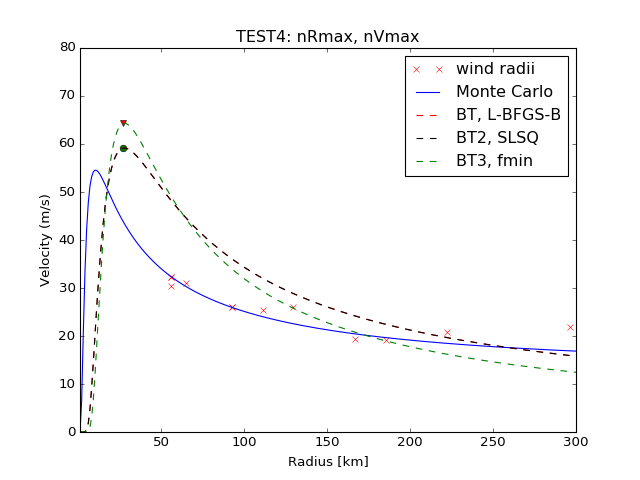

In [103]:
plt.figure(figsize=(8,6))
plt.plot(rmaxBT/1000, vmaxBT0k, 'og')
plt.plot(rmaxBT/1000, vmaxBT, 'vr')
plt.plot(R/1000,V,'rx',label='wind radii')
plt.plot(rh/1000, v_MCPY,'b-',label='Monte Carlo')
plt.plot(rh/1000, v4_LBF,'r--', label='BT, L-BFGS-B')
plt.plot(rh/1000, v4_SLS,'k--', label='BT2, SLSQ')
plt.plot(rh/1000, v4_min,'g--', label='BT3, fmin')

#plt.plot(rh/1000, v_BT0,'r-', label='BT')
#plt.plot(rh/1000, v_BT0k,'g--', label='BT')

plt.axis([r.min()/1000,300.,0.,80.])
plt.xlabel('Radius [km]')
plt.ylabel('Velocity (m/s)')
plt.title('TEST4: nRmax, nVmax')
plt.legend()
plt.show()

### 2.2.5) TEST 5: 
##### Input: vmax, dp (dpmin & dpmax), Rmax, Wind RADII 
##### Unknown: B, K

Pn Unknown

In [93]:
# p[0] = B
# p[1] = dP
# p[2] = k

from scipy.optimize import minimize, fmin_slsqp

def slsqp5(R,V,maxR,rho,vmax, rmax, pn, pc):
        dpmin=(pn-pc)-100  # minimum value of  pressure drop P_central - P_env(=101kPa).
        dpmax=(pn-pc)+100   # maximum value of  pressure drop P_central - P_env(=101kPa).
        kmin=0  # low limit of parameter k (=xn-.5-> k=0-> x=0.5)
        kmax=0.15 # upper limit for k (->xn=.65)  WHY?
        bmin=0.8
        bmax=1.8

        def func(p,x): # v(r) Holland
                 return (p[0]/rho*(rmax/x)**p[0]*p[1]*np.exp(-(rmax/x)**p[0]))**(0.5+(x-p[1])/(maxR-rmax)*p[2])

        def errf(p,x,y):
            return np.sum((func(p,x)-y)**2)

        def cf(p,x,y): # Holland parameter (B)
                 return p[0]-vmax**2*rho*np.exp(1.)/p[1]

        
        p0=[1.2,400,.15] # b, dp, x (funzione di k) prima 0.5

        bp=[(bmin,bmax),(dpmin,dpmax),(kmin,kmax)]

        
        res1 = minimize(errf, p0, args=(R, V), method='L-BFGS-B', bounds=bp, \
                        options={'disp': True, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})

        res2 = minimize(errf, p0, args=(R, V), method='SLSQP', bounds=bp, tol=1e-3, options={'disp': True, 'iprint': 1, 'eps': 1.4901161193847656e-08, 'maxiter': 100, 'ftol': 1e-06})

        res3 = fmin_slsqp(errf, p0, bounds=bp, args=(R, V),f_ieqcons=cf,acc=1e-5)
        
        
        return func,res1.x,res2.x, res3

In [94]:
fitf5,p2,p3,p4=slsqp5(R,V,maxR,rhoa,vmaxBT0k, rmaxBT, pnBT, pcBT) 

print 'B: ', p2[0], p3[0], p4[0]
print 'DP: ', p2[1]/100, p3[1]/100, p4[1]/100
print 'k: ', p2[2], p3[2], p4[2]



Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 438.741785923
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 438.741785923
            Iterations: 6
            Function evaluations: 11
            Gradient evaluations: 2
B:  0.8 1.0047444144 1.0047444144
DP:  71.0 36.7055794992 36.7055794992
k:  0.0 0.149973513648 0.149973513648


##### Calculate Pressure and winds

In [95]:
v_BT1=vel(rh,p2[0],rhoa,rmaxBT,maxR,p2[2], p2[1])
v_BT2=vel(rh,p3[0],rhoa,rmaxBT,maxR,p3[2],p3[1])
v_BT3=vel(rh,p4[0],rhoa,rmaxBT,maxR,p4[2], p4[1])

#(r,b,rhoa,rmax,maxR,kh,dp)

##### PLOT

<IPython.core.display.Javascript object>


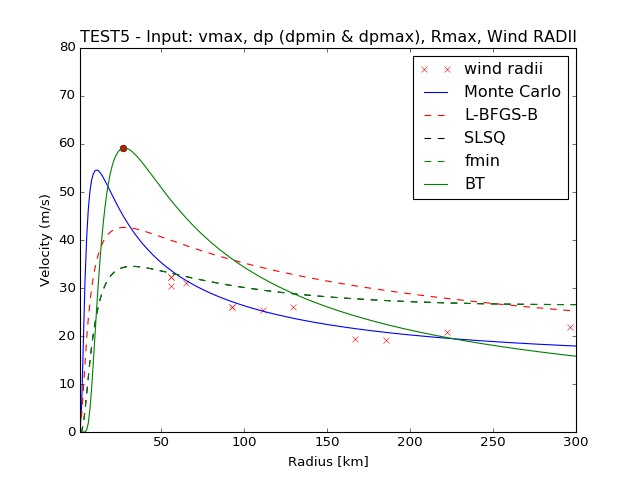

In [96]:
plt.figure(figsize=(8,6))
plt.plot(rmaxBT/1000, vmaxBT*fk, 'or')
plt.plot(R/1000,V,'rx',label='wind radii')
plt.plot(rh/1000, v_MCPY,'b-',label='Monte Carlo')
plt.plot(rh/1000, v_BT1,'r--', label='L-BFGS-B')
plt.plot(rh/1000, v_BT2,'k--', label='SLSQ')
plt.plot(rh/1000, v_BT3,'g--', label='fmin')

plt.plot(rh/1000, v_BT0k,'g-', label='BT')

plt.axis([r.min()/1000,300.,0.,80.])
plt.xlabel('Radius [km]')
plt.ylabel('Velocity (m/s)')
plt.title('TEST5 - Input: vmax, dp (dpmin & dpmax), Rmax, Wind RADII')
plt.legend()
plt.show()